# Going Deeper 03
## 프로젝트: CAM을 만들고 평가해보자

### 프로젝트 구성
1. CAM 구현하기
2. Grad-CAM 구현하기
3. 바운딩 박스 구하기
4. IoU 구하기

### 프로젝트 목표
1. CAM을 얻기 위한 기본모델의 구성과 학습 정상 진행
    - ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.
2. 분류근거를 설명 가능한 Class activation map을 얻기
    - CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.
3. 인식결과의 시각화 및 성능 분석
    - CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.

In [1]:
#tensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('슝💨')

슝💨


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# stanford_dogs 데이터셋을 불러오겠습니다.
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

print('슝💨')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
슝💨


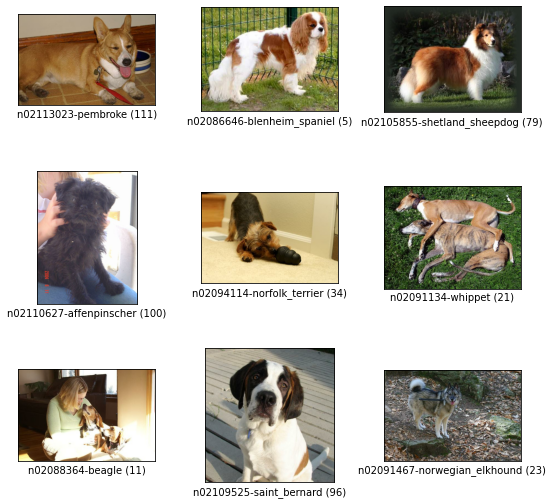

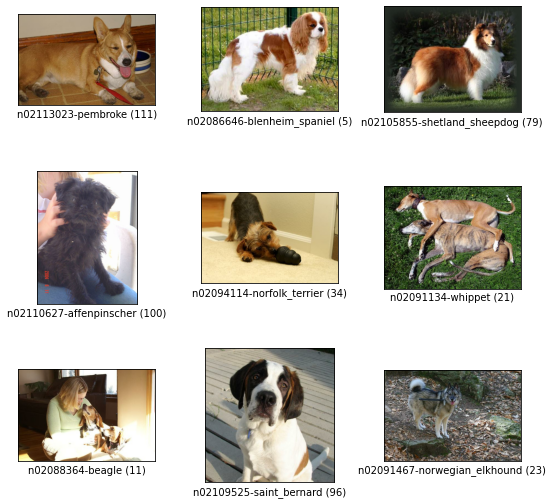

In [4]:
# train, test image 확인
tfds.show_examples(ds_train, ds_info)

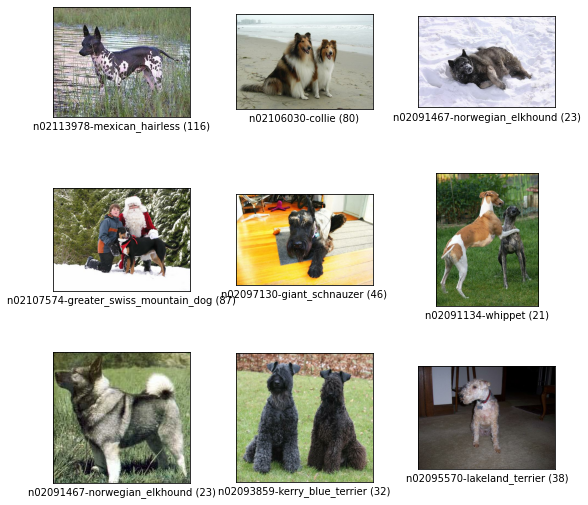

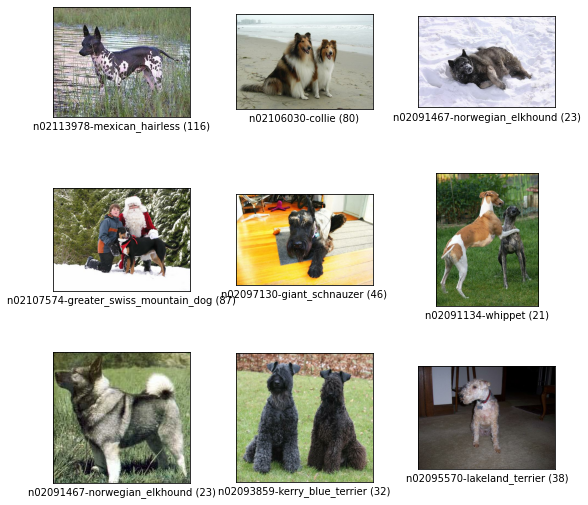

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

image, label 정보가 담겨 있고, **bbox**라는 것이 등장했습니다. bbox(바운딩 박스)는 아래 그림과 같이 물체의 위치를 사각형 영역으로 표기하는 방법입니다.

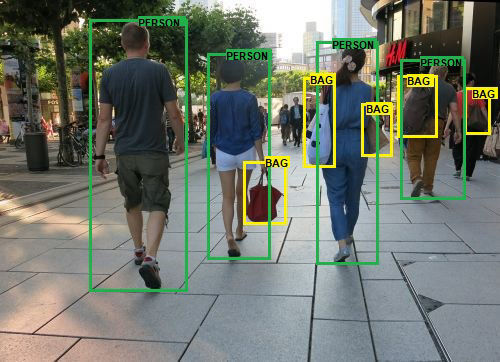

## CAM 모델 만들기

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94773248/94765736 [==============================] - 1s 0us/step


CAM 모델은 classification model과 크게 다른 점이 없지만, 마지막 fully connected layer 대신 GAP을 사용한다. ResNet50의 매개변수 pooling에 'avg'를 전달하여 GAP 연산을 붙일 수 있다.

In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

CAM은 특성 맵(feature map)을 사용해 만든다.

> 위 레이어 중 사용하는 feature map은 **conv5_block3_out의 output**이다.

따라서 이 feature map에 Global average pooling을 하여 feature의 크기를 줄이고, 줄어든 feature 전체에 Dense layer를 붙여 classification을 수행한다.

## CAM 모델 학습하기

- normalize_and_resize_img: train, validation data에 normalizing과 resizing을 포함한 전처리 수행
- apply_normalize_on_dataset: 위 과정을 포함한 배치 구성

input에 이전과 다르게 bbox 정보가 포함되어있지만, 지금 수행해야 할 CAM 모델의 학습에는 필요가 없으므로 normalize_and_resize_img과정에서 제외하였다.

CAM 모델은 bounding box 같은 직접적인 라벨을 사용하지 않고 weakly supervised leraning을 통해 물체 영역을 간접적으로 확인하는 방법이다.

In [9]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝💨')    

슝💨


In [10]:
# dataset에 전처리와 배치처리 적용
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양 확인
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

print('슝💨') 

슝💨


In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 352s 432ms/step - loss: 3.1701 - accuracy: 0.2838 - val_loss: 3.3871 - val_accuracy: 0.1989
Epoch 2/15
750/750 [==============================] - 314s 419ms/step - loss: 0.8619 - accuracy: 0.7647 - val_loss: 1.1488 - val_accuracy: 0.6650
Epoch 3/15
750/750 [==============================] - 315s 420ms/step - loss: 0.2872 - accuracy: 0.9370 - val_loss: 0.9296 - val_accuracy: 0.7277
Epoch 4/15
750/750 [==============================] - 315s 420ms/step - loss: 0.0735 - accuracy: 0.9929 - val_loss: 0.8932 - val_accuracy: 0.7439
Epoch 5/15
750/750 [==============================] - 315s 420ms/step - loss: 0.0299 - accuracy: 0.9994 - val_loss: 0.9032 - val_accuracy: 0.7384
Epoch 6/15
750/750 [==============================] - 315s 420ms/step - loss: 0.0171 - accuracy: 0.9997 - val_loss: 0.9182 - val_accuracy: 0.7401
Epoch 7/15
750/750 [==============================] - 315s 420ms/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.9194 -

In [13]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)
print("저장 완료👏")

저장 완료👏


In [14]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝💨')

슝💨


학습된 모델에서 CAM 생성 - CAM 생성 과정은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어짐.

## CAM

In [24]:
# Dataset에서 한 장씩 
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('슝💨')

슝💨


100


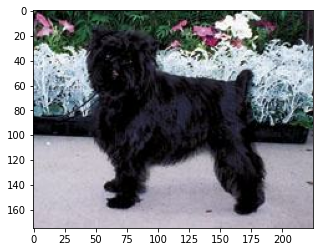

In [25]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [28]:
# 학습한 모델 불러오기
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

print('슝💨')

슝💨


#### CAM 생성을 위해 필요한 것
1. feature map
2. class별 확률을 얻기 위한 softmax layer의 weight
3. 원하는 class의 output

이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에 나온 CAM을 이미지 사이즈와 같게 만들어 함께 시각화 해야 함.
- model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수 만들기
- generate_cam()을 구현: conv_outputs와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현
- 입력 이미지에 맞춰 CAM을 resize해주기

In [35]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    ## 학습한 모델에서 원하는 layer의 output을 얻기 위해 모델의 input과 output을 새롭게 정의
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolutuon layer의 output을 얻을 수 있음
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] # 마지막 모델의 weight activation 가져오기
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f를 통해 class별 activation map 계산
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize하기
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize
    return cam_image

print('슝💨')

슝💨


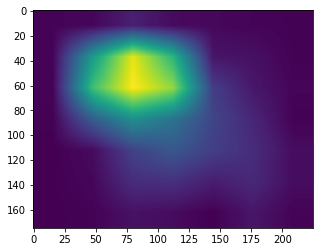

In [36]:
# 위 함수 실행
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [37]:
# CAM 이미지를 원본 이미지와 합치기
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

print('슝💨')

슝💨


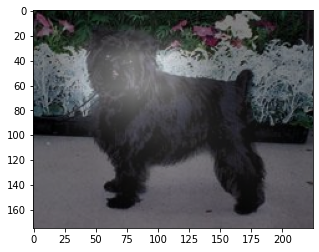

In [39]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

생성된 CAM이 개를 식별하는데 중요한 이미지 부분을 잘 포착하고 있다. 주로 강아지의 얼굴과 몸통이 있는 부분이 강조되는 경향이 있으며, 이것은 사람이 개를 식별할 때 유의해서 보는 부분과 비슷하다.

## Grad-CAM

Grad-CAM을 이용해 CAM 얻기. 적용 모델에 유연하게 선택할 수 있는 Grad-CAM 특성 상 위에서 만든 모델을 다시 활용하기. 관찰 대상 모델은 cam_model 활용

100


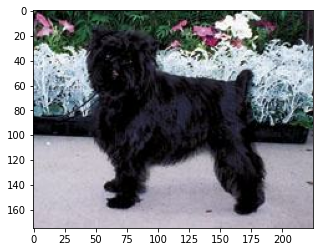

In [40]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

### Grad-CAM을 이용해서 CAM을 만들기
- grad_cam은 관찰을 원하는 layer와 정답 class에 대한 예측값 사이의 그레디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구함
- 최종 CAM 이미지를 구하기 위해서는 layer의 channel별 weight와 layer에서 나온 channel별 feature map을 가중합해주어 cam_image를 얻음
- CAM 함수와 달리 Grad-CAM은 어떤 layer든 CAM image를 뽑아낼 수 있으므로, gradient 계산을 원하는 관찰 대상 layer, activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 활용
- generate_grad_cam()에서는 원하는 layer의 output과 특정 class의 prediction 사이의 gradient grad_val을 얻고 이를 weights로 활용

In [45]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape 사용
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor,0))
        
        loss = pred[:, class_idx] # 원하는 class 예측값 얻기
        output = conv_output[0]
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient 얻기
        
    weights = np.mean(grad_val, axis=(0,1)) # gradient의 GAP으로 class별 weight를 구함
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map 얻기
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('슝💨')

슝💨


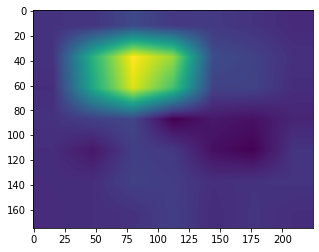

In [46]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out',item)
plt.imshow(grad_cam_image)
plt.show()

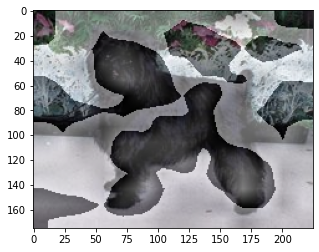

In [49]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

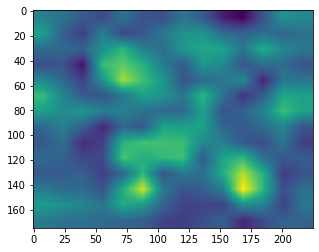

In [51]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

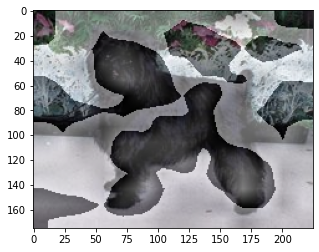

In [52]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

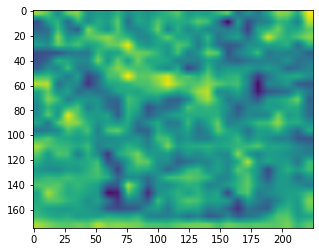

In [53]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

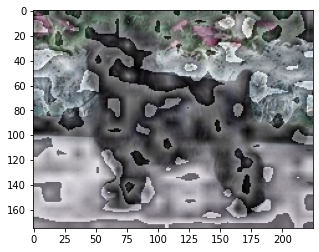

In [54]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

## Detection with CAM

### Bounding box

67


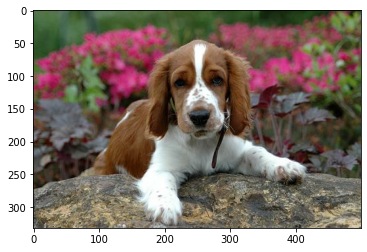

In [87]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

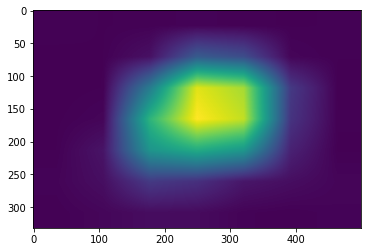

In [88]:
# 이전 스텝에서 만들었던 generate_cam()을 활용해서 CAM 이미지를 뽑기
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

#### get_bbox() 함수

1. 바운딩 박스를 만들기 위해서 score_thresh를 받아 역치값 이하의 바운딩 박스는 없앤다.
2. OpenCV의 findContours()와 minAreaRect()로 사각형을 찾는다.
3. 이때 rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있다.
4. boxPoints()로 이를 꼭지점으로 바꾼다.
5. 마지막에는 int 자료형으로 변환

In [89]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('슝💨')

슝💨


In [90]:
# cam_image를 통해 bbox를 얻고 이를 이미지 위에 시각화한 모습
rect = get_bbox(cam_image)
rect

array([[107,  31],
       [441,  31],
       [441, 300],
       [107, 300]])

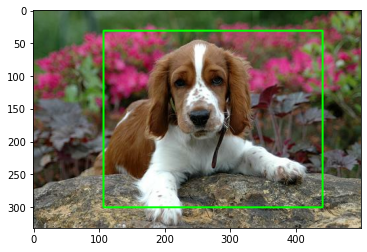

In [91]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0.0,255), 2)
plt.imshow(image)
plt.show()

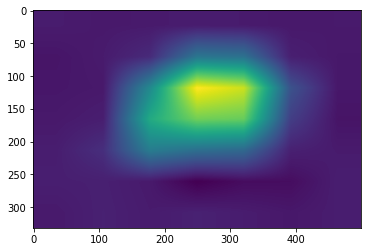

In [92]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

In [93]:
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[ 74,  37],
       [439,  19],
       [449, 240],
       [ 85, 258]])

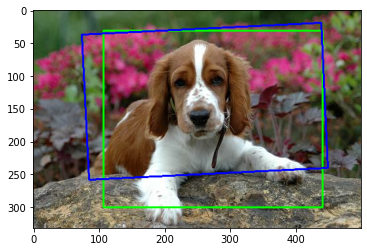

In [94]:
image = cv2.drawContours(image,[grad_rect],0,(0,0,255),2)
plt.imshow(image)
plt.show()

## IoU(Intersection Over Union)

CAM과 Grad-CAM 두 가지 방법을 통해서 바운딩 박스를 얻었음. 정답 데이터인 바운딩 박스와 어떻게 비교할 수 있는가?

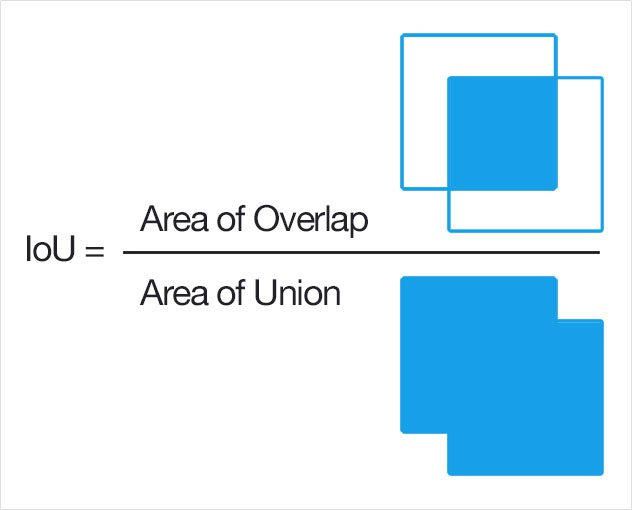

IoU(Intersection over Union)는 두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값이다. 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있으므로, 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 된다.

In [95]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어짐
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]), # bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]), # bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), # bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]), # bounding box의 x_max
    ]
    return bbox

print('슝💨')

슝💨


In [96]:
# cam_image를 통한 bbox를 minmax bbox 형태로 치환
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.09337349397590361, 0.214, 0.9036144578313253, 0.882]

In [100]:
# grad_cam_image를 통한 bbox를 minmax bbox 형태로 치환
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
pred_bbox

[0.09337349397590361, 0.214, 0.9036144578313253, 0.882]

In [97]:
# ground truth bbox
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [98]:
# CAM 추론 결과로 얻어진 bbox가 ground truth bbox와 비슷한지 IoU 계산해서 확인
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min = max(boxA[1], boxB[1])
    y_max = max(boxA[2], boxB[2])
    x_max = max(boxA[3], boxB[3])
    
    interArea = max(0, x_max-x_min) * max(0, y_max-y_min)
    boxAArea = (boxA[2] - boxA[0] * (boxA[3] - boxA[1]))
    boxBArea = (boxB[2] - boxB[0] * (boxB[0] - boxB[1]))
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

print('슝💨')

슝💨


In [101]:
# cam bbox와 ground truth bbox와 비슷한지
get_iou(pred_bbox, item['objects']['bbox'][0])

0.4514822311552428

In [102]:
# grad_cam bbox와 ground truth bbox와 비슷한지
get_iou(grad_pred_bbox, item['objects']['bbox'][0])

0.5896315131835643

## 프로젝트 과정에 따른 정리
1. CAM을 얻기 위한 기본 모델을 구성하고 학습을 정상적으로 진행함
2. ResNet50 + GAP + DenseLayer가 결합된 모델을 만들었음
3. 분류 근거를 위한 CAM, Grad-CAM 방식의 class activation map을 얻음
4. 시각화하였을 때, object의 주요 특징 위치를 잘 반영하였음
5. 원본 이미지 합성, Bounding Box, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능 비교 가능

## 프로젝트 결과

| |CAM|Grad-CAM|
|------|---|---|
|Image|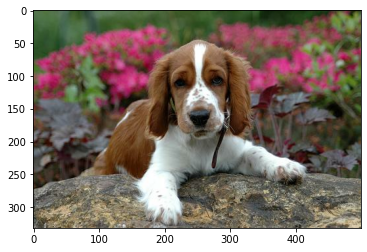|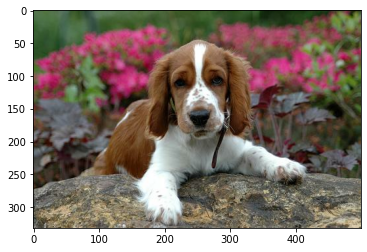|
|Bbox|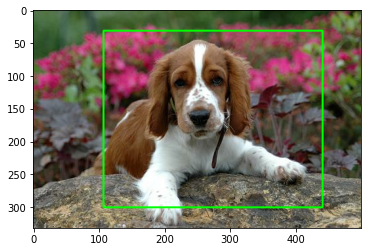|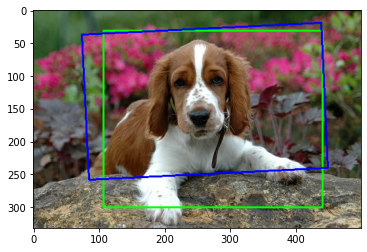|
|CAM|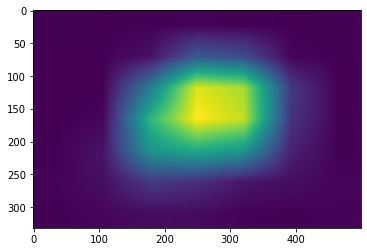|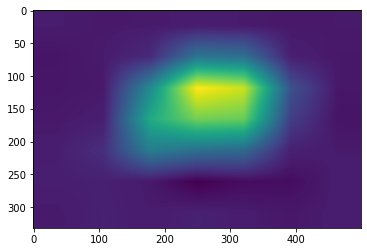|
|IoU|0.4514822311552428|0.5896315131835643|

## 결과 분석

1. CAM, Grad-CAM 모두 object를 잘 찾았다. CAM은 강아지의 얼굴 부위에 더 집중되어 있고, Grad-CAM은 CAM보다는 더 작은 특정 부위에 덜 진하게 집중되어 있었다.
2. Bbox의 경우 CAM의 경우 object detection을 green bbox 하나로 한 반면에, Grad-CAM은 green, blue 두 개로 bbox가 detection 되었다.
3. bbox가 겹치게 나오는 경우 임계값 이상으로 볼 수 있고 이를 제거하여 중복을 제거해줄 수 있다. 중복을 제거하는 기준은 둘 중 하나는 중복일 것이라는 판단 하에 신뢰도가 더 낮은 것을 지워주면 된다.
4. IoU의 경우 Grad-CAM이 더 높은 점수를 보여주었다. Grad-CAM의 blue box가 실제 ground truth와 겹치는 영역이 더 넓었을 것이라고 짐작할 수 있다.